In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [2]:
# %cd D:\Learning\University\UIT\AI\Projects\AI4Finance\Recode

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Install necessary independences

In [4]:
!pip install wrds
!pip install swig
!pip install PyPortfolioOpt
!pip install pyfolio-reloaded
!pip install -q condacolab
!pip install stockstats
!pip install gym
!pip install gymnasium
!pip install stable_baselines3
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig

  Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.
  Using cached scipy-1.13.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.13.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
ERROR: pip's dependency resolver

In [5]:
import sys
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
from plot import backtest_plot, get_baseline, backtest_stats
%matplotlib inline
from preprocessor.preprocessors import FeatureEngineer, data_split
from env.env_stocktrading import StockTradingEnv
from models.models import DRLAgent,DRLEnsembleAgent
from stable_baselines3.common.logger import configure
from stable_baselines3 import A2C, DDPG, PPO

from pprint import pprint

import itertools

In [6]:
from config.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
    check_and_make_directories
)
from config.config_tickers import DOW_30_TICKER

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

## Read data

We first read the .csv file of our training data into dataframe.

In [7]:
processed_data = pd.read_csv(DATA_SAVE_DIR + 'processed_full.csv')
processed_data = processed_data.set_index(processed_data.columns[0])
processed_data.index.names = ['']

In [8]:
train = data_split(processed_data, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_data, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

29232
14500


In [9]:
TRAIN_END_DATE

'2022-01-01'

In [10]:
train.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2018-01-02,AAPL,42.540001,43.075001,42.314999,40.670971,102223600.0,1.0,0.0,0.0,66.666667,100.0,9.77,0.0
0,2018-01-02,AMGN,175.350006,177.820007,174.419998,146.429108,2301100.0,1.0,0.0,0.0,66.666667,100.0,9.77,0.0
0,2018-01-02,AXP,99.730003,99.730003,98.220001,90.226944,2746700.0,1.0,0.0,0.0,66.666667,100.0,9.77,0.0
0,2018-01-02,BA,295.750000,296.989990,295.399994,282.886414,2978900.0,1.0,0.0,0.0,66.666667,100.0,9.77,0.0
0,2018-01-02,CAT,158.300003,159.389999,156.029999,134.870636,5108400.0,1.0,0.0,0.0,66.666667,100.0,9.77,0.0


In [11]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
1007,2021-12-31,UNH,504.140015,506.869995,502.040009,484.463928,1695400.0,4.0,12.928914,66.917702,105.219094,35.524631,17.219999,12.137917
1007,2021-12-31,V,216.809998,217.979996,215.490005,212.991302,4723300.0,4.0,2.616086,51.608553,86.144479,0.410017,17.219999,12.137917
1007,2021-12-31,VZ,52.200001,52.310001,51.880001,44.412312,15911400.0,4.0,0.200583,48.646226,41.490886,10.681208,17.219999,12.137917
1007,2021-12-31,WBA,51.900002,52.419998,51.830002,45.353912,3406700.0,4.0,0.966713,60.665078,137.655018,25.778533,17.219999,12.137917
1007,2021-12-31,WMT,47.733334,48.346668,47.639999,46.611462,17947800.0,4.0,0.035970,52.959531,77.948767,1.606327,17.219999,12.137917


In [12]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2022-01-03,AAPL,177.830002,182.880005,177.710007,179.724533,104487900.0,0.0,4.767874,64.844852,102.677577,42.087725,16.6,40.628291
0,2022-01-03,AMGN,223.630005,226.970001,222.029999,210.740341,2742800.0,0.0,4.504905,60.592151,90.703115,20.989652,16.6,40.628291
0,2022-01-03,AXP,164.509995,168.399994,164.399994,162.605331,3236400.0,0.0,-0.638614,50.972514,59.310205,1.754196,16.6,40.628291
0,2022-01-03,BA,204.000000,210.550003,203.339996,207.860001,9060200.0,0.0,-0.982440,49.747896,65.232126,3.639708,16.6,40.628291
0,2022-01-03,CAT,207.330002,208.600006,205.800003,196.558151,2055600.0,0.0,1.291196,53.031031,98.541070,6.201519,16.6,40.628291


In [13]:
trade.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
499,2023-12-28,UNH,523.469971,527.869995,522.940002,520.630310,2001000.0,3.0,-4.482944,48.544493,-86.554479,9.418188,12.47,7.060585
499,2023-12-28,V,258.540009,260.970001,258.540009,259.915344,3020500.0,3.0,2.767469,61.502711,102.513885,26.012559,12.47,7.060585
499,2023-12-28,VZ,37.180000,37.720001,37.150002,36.280758,14931700.0,3.0,0.248021,57.521271,-7.145725,15.051402,12.47,7.060585
499,2023-12-28,WBA,26.590000,27.020000,26.389999,25.939976,7899900.0,3.0,1.399880,64.322401,118.533676,35.833180,12.47,7.060585
499,2023-12-28,WMT,52.590000,52.776669,52.500000,52.345058,16776000.0,3.0,-0.069524,50.536042,89.737088,0.984013,12.47,7.060585


In [14]:
print(f"Train shape: {train.shape}")
print(f"Trade shape: {trade.shape}")

Train shape: (29232, 14)
Trade shape: (14500, 14)


## Construct the environment

Calculate and specify the parameters we need for constructing the environment.

In [15]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [16]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [17]:
train

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2018-01-02,AAPL,42.540001,43.075001,42.314999,40.670971,102223600.0,1.0,0.000000,0.000000,66.666667,100.000000,9.770000,0.000000
0,2018-01-02,AMGN,175.350006,177.820007,174.419998,146.429108,2301100.0,1.0,0.000000,0.000000,66.666667,100.000000,9.770000,0.000000
0,2018-01-02,AXP,99.730003,99.730003,98.220001,90.226944,2746700.0,1.0,0.000000,0.000000,66.666667,100.000000,9.770000,0.000000
0,2018-01-02,BA,295.750000,296.989990,295.399994,282.886414,2978900.0,1.0,0.000000,0.000000,66.666667,100.000000,9.770000,0.000000
0,2018-01-02,CAT,158.300003,159.389999,156.029999,134.870636,5108400.0,1.0,0.000000,0.000000,66.666667,100.000000,9.770000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,2021-12-31,UNH,504.140015,506.869995,502.040009,484.463928,1695400.0,4.0,12.928914,66.917702,105.219094,35.524631,17.219999,12.137917
1007,2021-12-31,V,216.809998,217.979996,215.490005,212.991302,4723300.0,4.0,2.616086,51.608553,86.144479,0.410017,17.219999,12.137917
1007,2021-12-31,VZ,52.200001,52.310001,51.880001,44.412312,15911400.0,4.0,0.200583,48.646226,41.490886,10.681208,17.219999,12.137917
1007,2021-12-31,WBA,51.900002,52.419998,51.830002,45.353912,3406700.0,4.0,0.966713,60.665078,137.655018,25.778533,17.219999,12.137917


In [18]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for training

In [19]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Train DRL Agents

In [20]:
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_ensemble = True

### Agent 1: A2C

In [21]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + 'a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [22]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=20000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 65          |
|    iterations         | 100         |
|    time_elapsed       | 7           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.2       |
|    explained_variance | 0.698       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 23.1        |
|    reward             | 0.024734754 |
|    std                | 1           |
|    value_loss         | 0.341       |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 70        |
|    iterations         | 200       |
|    time_elapsed       | 14        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | 0.243     |
|    learning_rate

In [23]:
trained_a2c.save(TRAINED_MODEL_DIR + "agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [24]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + 'ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg


In [25]:
trained_ddpg = agent.train_model(model=model_ddpg,
                            tb_log_name='ddpg',
                            total_timesteps=20000) if if_using_ddpg else None

Episode: 22
Episode: 23
Episode: 24
Episode: 25
------------------------------------
| time/              |             |
|    episodes        | 4           |
|    fps             | 82          |
|    time_elapsed    | 48          |
|    total_timesteps | 4032        |
| train/             |             |
|    actor_loss      | 53.4        |
|    critic_loss     | 178         |
|    learning_rate   | 0.001       |
|    n_updates       | 3931        |
|    reward          | -0.04534058 |
------------------------------------
Episode: 26
Episode: 27
Episode: 28
Episode: 29
------------------------------------
| time/              |             |
|    episodes        | 8           |
|    fps             | 84          |
|    time_elapsed    | 95          |
|    total_timesteps | 8064        |
| train/             |             |
|    actor_loss      | 40.8        |
|    critic_loss     | 0.692       |
|    learning_rate   | 0.001       |
|    n_updates       | 7963        |
|    reward     

In [26]:
trained_ddpg.save(TRAINED_MODEL_DIR + "agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [27]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + 'ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


In [28]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=20000) if if_using_ppo else None

Episode: 42
Episode: 43
-----------------------------------
| time/              |            |
|    fps             | 177        |
|    iterations      | 1          |
|    time_elapsed    | 11         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.05710453 |
-----------------------------------
Episode: 44
Episode: 45
-----------------------------------------
| time/                   |             |
|    fps                  | 169         |
|    iterations           | 2           |
|    time_elapsed         | 24          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017482497 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0424     |
|    learning_rate        | 0.00025     |
|    loss                 | 3.26        |
|    n_updates            | 10          

In [29]:
trained_ppo.save(TRAINED_MODEL_DIR + "agent_ppo") if if_using_ppo else None

## Implement DRL Algorithms

In [30]:
ensemble_data = pd.concat([train, trade])

In [31]:
rebalance_window = 63
validation_window = 63

env_ensemble_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

ensemble_agent = DRLEnsembleAgent(df=ensemble_data,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TRADE_START_DATE,TRADE_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_ensemble_kwargs) if if_using_ensemble else None

In [32]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 20000,
                 'ppo' : 20000,
                 'ddpg' : 20000,
                 }

In [33]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict) if if_using_ensemble else None

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
|    explained_variance | -0.0144   |
|    learning_rate      | 0.0007    |
|    n_updates          | 999       |
|    policy_loss        | -254      |
|    reward             | 2.6416326 |
|    std                | 0.994     |
|    value_loss         | 42.6      |
-------------------------------------
Episode: 5
day: 1070, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 1568851.39
total_reward: 568851.39
total_cost: 61100.22
total_trades: 21003
Sharpe: 0.618
--------------------------------------
| time/                 |            |
|    fps                | 150        |
|    iterations         | 1100       |
|    time_elapsed       | 36         |
|    total_timesteps    | 5500       |
| train/                |            |
|    entropy_loss       | -41        |
|    explained_variance | 0.0575     |
|    learning_rate      | 0.0007     |
|    n_updates          | 1099       |
|    policy_loss        | -27.9      |
|

In [34]:
df_summary if if_using_ensemble else None

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2022-01-03,2022-04-04,A2C,-0.024746,-0.108454,-0.068447
1,189,2022-04-04,2022-07-06,A2C,-0.160437,-0.259066,-0.25292
2,252,2022-07-06,2022-10-04,A2C,-0.080968,-0.185529,-0.094428
3,315,2022-10-04,2023-01-04,A2C,0.380992,0.18812,0.358399
4,378,2023-01-04,2023-04-05,DDPG,-0.050632,-0.043434,0.107677
5,441,2023-04-05,2023-07-07,A2C,0.303229,-0.060818,-0.082253


# Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [35]:
e_test_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [36]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "agent_ppo") if if_using_ppo else None

In [37]:
train_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_test_gym) if if_using_a2c else None

Episode: 2
hit end!


In [38]:
train_model = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_test_gym) if if_using_ppo else None

Episode: 5
hit end!


In [39]:
train_model = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_test_gym) if if_using_ddpg else None

Episode: 8
hit end!


==============Compare to DJIA===========
-----------DOWNLOADING-----------
From = 2022-01-01 to 2024-01-01.


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (501, 8)


Start date,2022-01-03
End date,2023-12-28
Total months,23
,Backtest
Annual return,6.277%
Cumulative returns,12.839%
Annual volatility,18.032%
Sharpe ratio,0.43
Calmar ratio,0.28
Stability,0.42
Max drawdown,-22.814%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.81,2022-01-03,2022-09-30,2023-04-13,334
1,11.63,2023-07-31,2023-10-27,2023-11-30,89
2,2.96,2023-04-13,2023-05-25,2023-06-02,37
3,2.39,2023-06-15,2023-06-26,2023-07-11,19
4,1.27,2023-06-02,2023-06-06,2023-06-08,5


Stress Events,mean,min,max
Covid,0.03%,-4.27%,3.14%


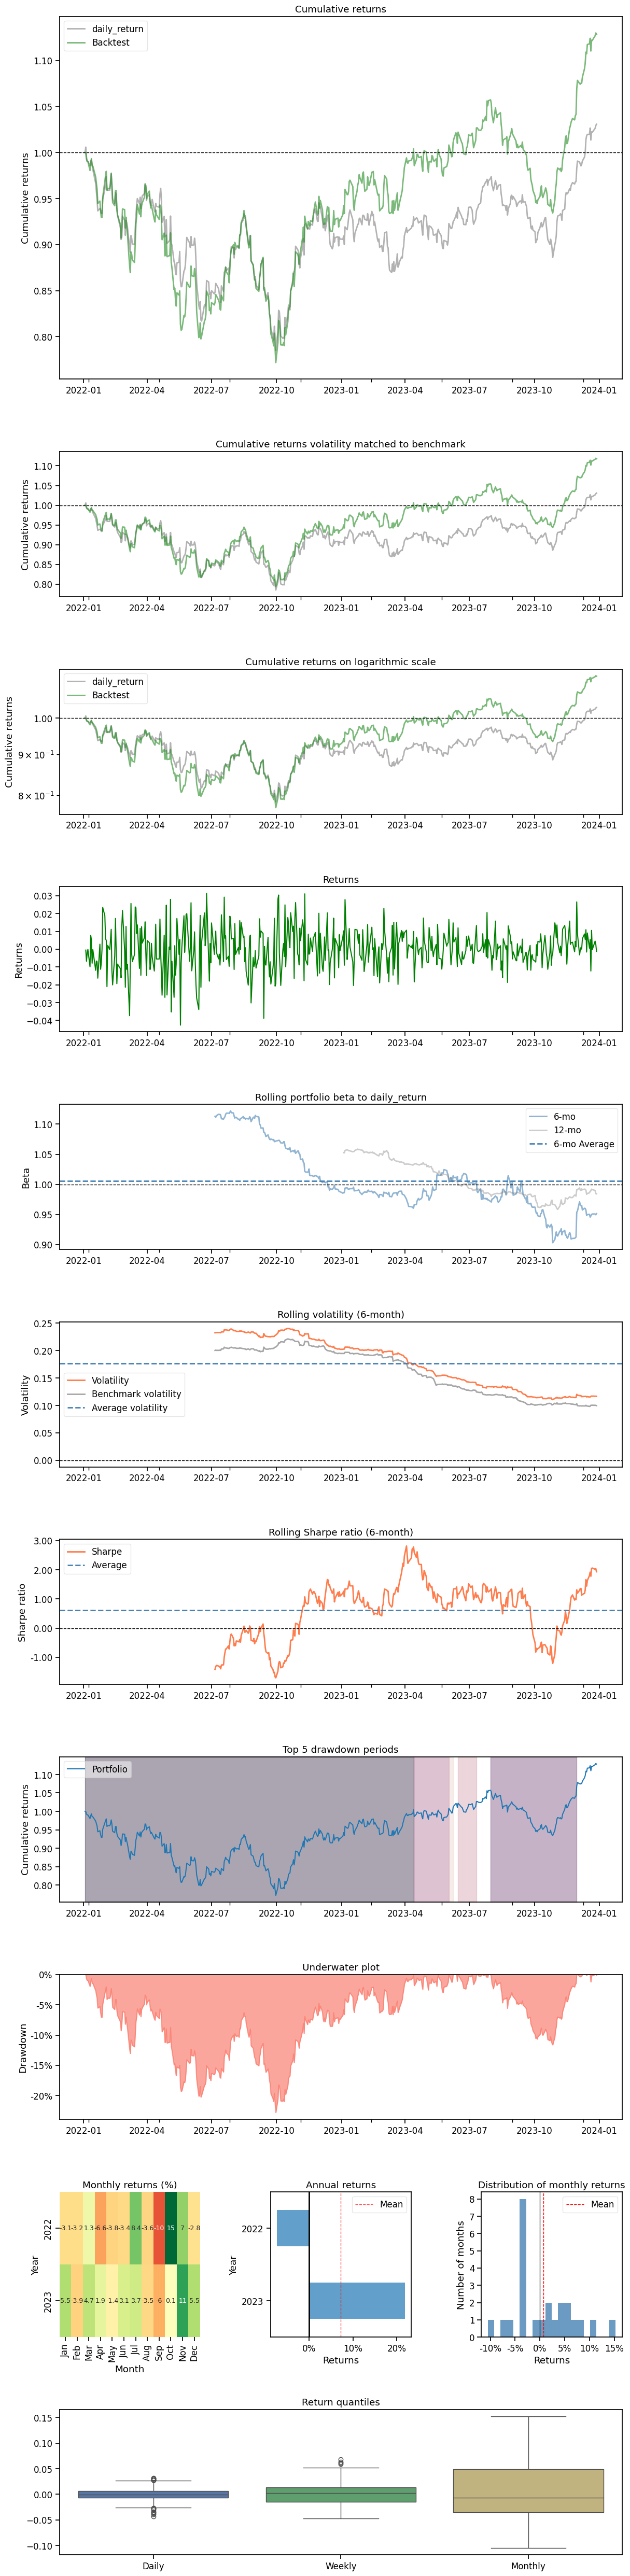

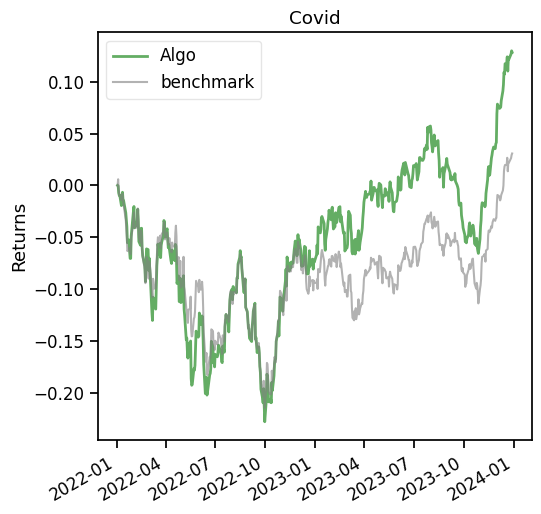

In [40]:
%matplotlib inline
print("==============Compare to DJIA===========")

# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

if if_using_a2c:
    backtest_plot(df_account_value_a2c,
                    baseline_ticker='^DJI',
                    baseline_start=TEST_START_DATE,
                    baseline_end=TEST_END_DATE)
    plt.show()

[*********************100%%**********************]  1 of 1 completed

-----------DOWNLOADING-----------
From = 2022-01-01 to 2024-01-01.
Shape of DataFrame:  (501, 8)


Start date,2022-01-03
End date,2023-12-28
Total months,23
,Backtest
Annual return,3.6%
Cumulative returns,7.269%
Annual volatility,17.463%
Sharpe ratio,0.29
Calmar ratio,0.15
Stability,0.26
Max drawdown,-23.671%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.67,2022-01-04,2022-09-30,2023-11-30,498
1,1.19,2023-12-19,2023-12-20,2023-12-26,6
2,0.68,2023-12-01,2023-12-06,2023-12-11,7
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
Covid,0.02%,-4.42%,4.56%


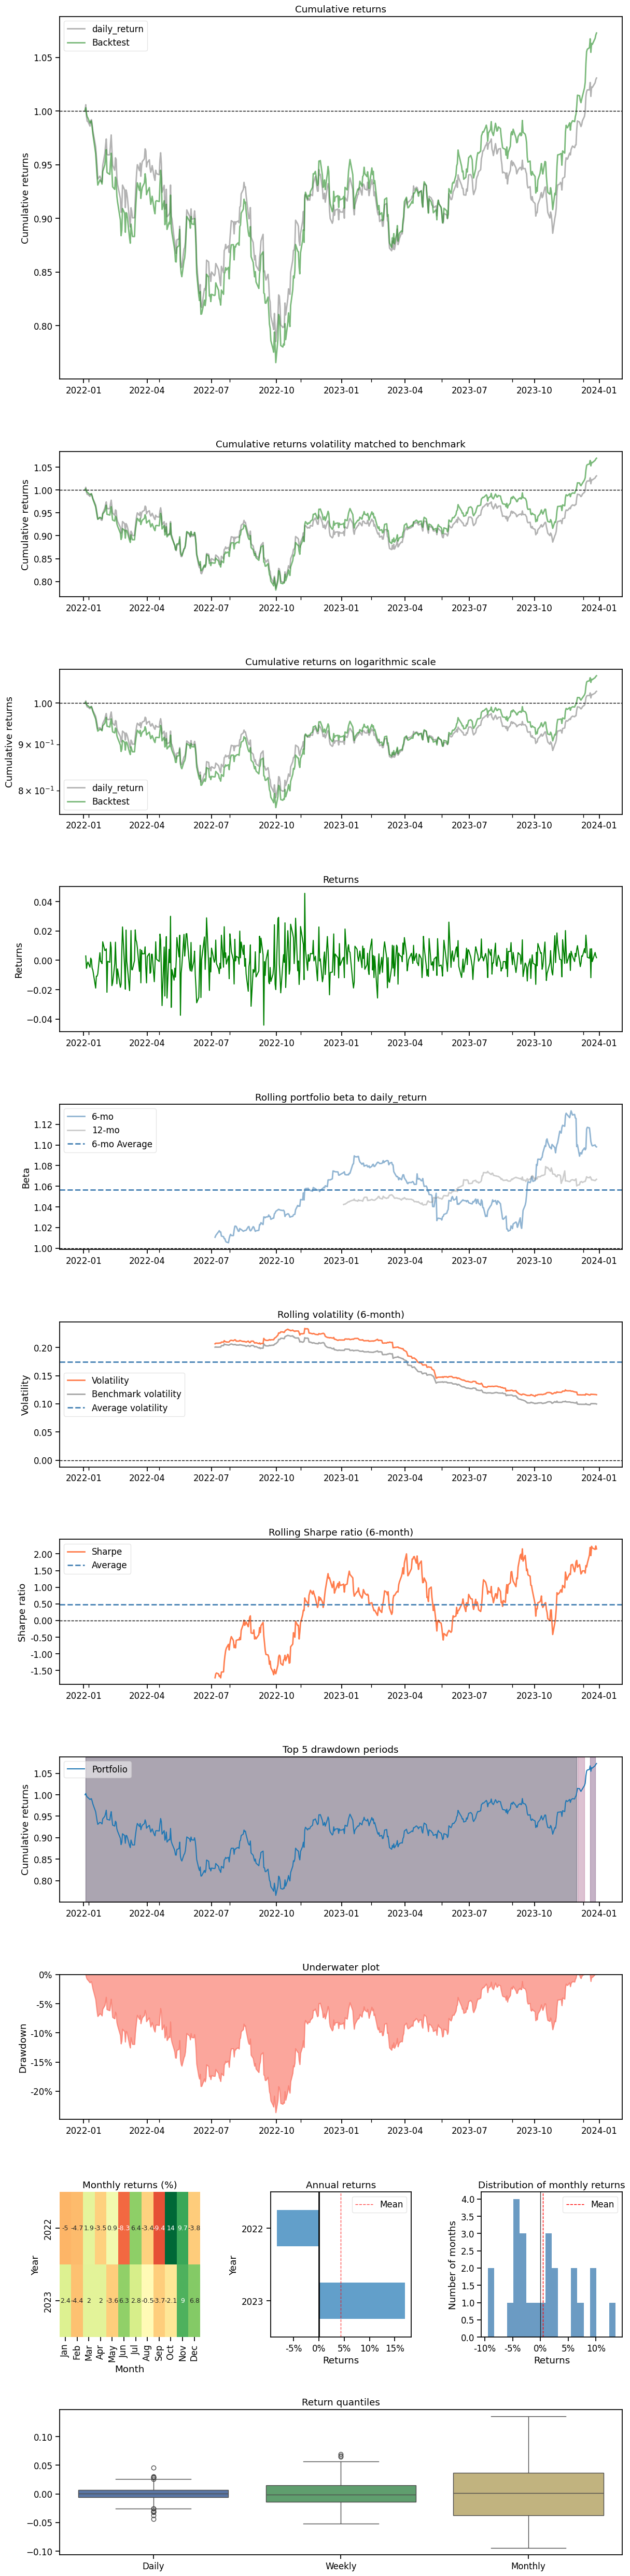

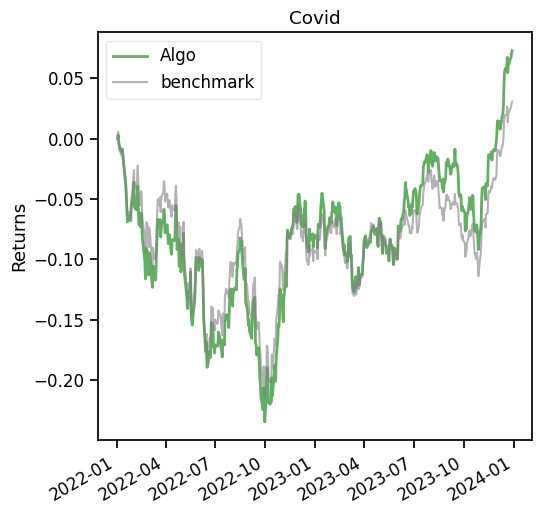

In [41]:
if if_using_ddpg:
    backtest_plot(df_account_value_ddpg,
                    baseline_ticker='^DJI',
                    baseline_start=TEST_START_DATE,
                    baseline_end=TEST_END_DATE)
    plt.show()

[*********************100%%**********************]  1 of 1 completed

-----------DOWNLOADING-----------
From = 2022-01-01 to 2024-01-01.
Shape of DataFrame:  (501, 8)


Start date,2022-01-03
End date,2023-12-28
Total months,23
,Backtest
Annual return,6.772%
Cumulative returns,13.885%
Annual volatility,19.522%
Sharpe ratio,0.43
Calmar ratio,0.30
Stability,0.35
Max drawdown,-22.308%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.31,2022-02-09,2022-09-30,2023-01-06,238
1,11.10,2023-08-07,2023-09-28,2023-11-29,83
2,6.71,2023-04-13,2023-05-25,2023-07-26,75
3,6.29,2023-02-01,2023-03-13,2023-04-13,52
4,4.40,2023-12-19,2023-12-22,NaT,NaN


Stress Events,mean,min,max
Covid,0.03%,-4.75%,5.39%


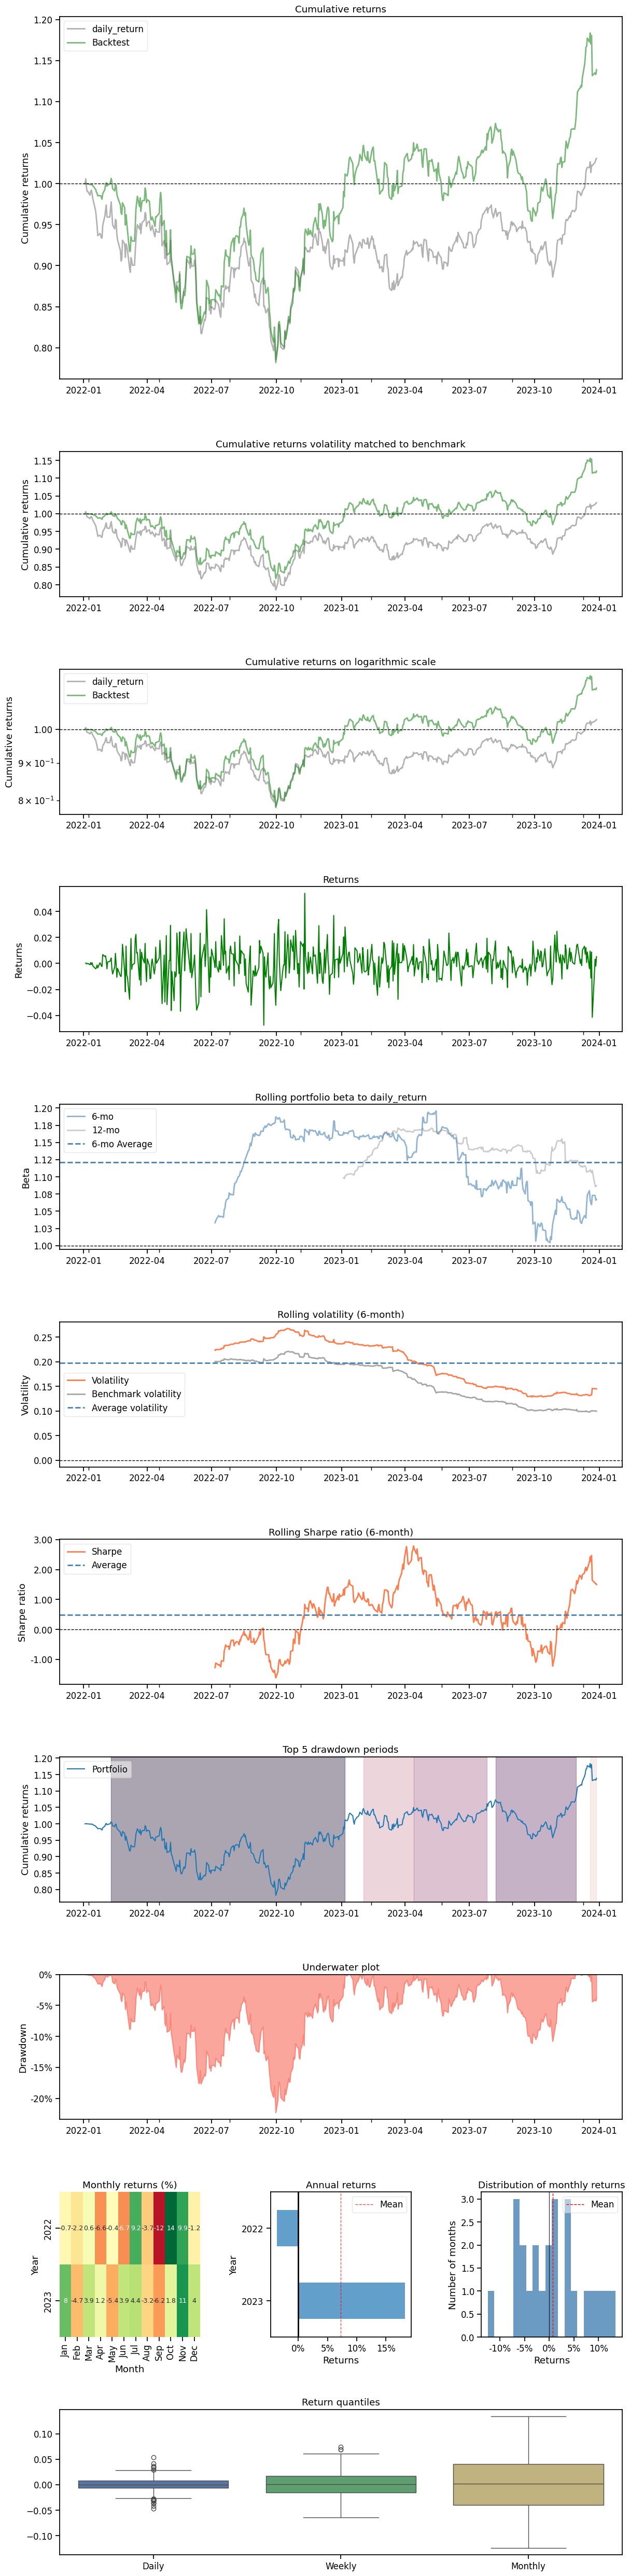

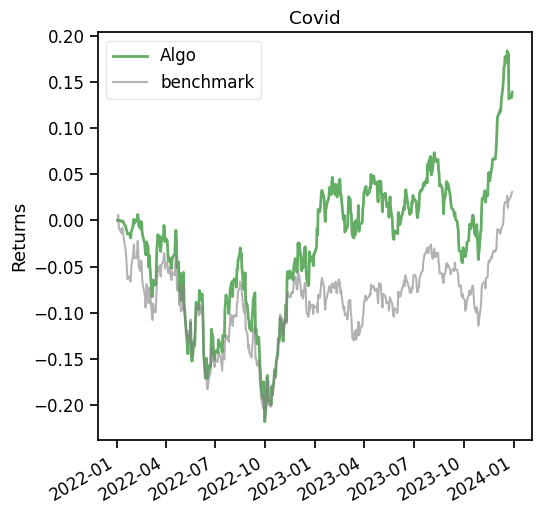

In [42]:

if if_using_ppo:
    backtest_plot(df_account_value_ppo,
                    baseline_ticker='^DJI',
                    baseline_start=TEST_START_DATE,
                    baseline_end=TEST_END_DATE)
    plt.show()


# Mean Variance Optimization
Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [43]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

In [44]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [45]:
train_mvo = data_split(processed_data, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_data, TEST_START_DATE,TEST_END_DATE).reset_index()

In [46]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[179.72453308, 210.74034119, 162.60533142, ...,  44.82258224,
         46.13647461,  46.59857559],
       [177.443573  , 211.80941772, 167.82542419, ...,  45.7029686 ,
         46.50167084,  45.74488831],
       [172.72360229, 209.29937744, 166.0370636 , ...,  46.173069  ,
         46.95381927,  46.36340332],
       ...,
       [192.8039856 , 281.69784546, 184.78863525, ...,  36.27108002,
         25.94972801,  51.95970154],
       [192.90383911, 284.3074646 , 185.88169861, ...,  36.10656357,
         25.97898293,  52.44804001],
       [193.33329773, 286.22247314, 186.61705017, ...,  36.2807579 ,
         25.93997574,  52.34505844]])

In [47]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.167 0.05  0.084 0.02  0.06  0.115 0.078 0.036 0.055 0.07  0.104 0.058
 0.025 0.048 0.04  0.07  0.049 0.065 0.002 0.059 0.158 0.118 0.079 0.044
 0.107 0.083 0.022 0.    0.056]
Variance-Covariance matrix of returns
 [[ 4.289  1.685  2.202  2.791  1.928  2.736  2.287  1.914  1.764  2.289
   2.12   1.822  1.712  2.762  1.225  1.939  1.162  1.484  1.626  1.183
   2.947  1.956  1.215  1.509  2.018  2.344  0.697  1.46   1.167]
 [ 1.685  2.845  1.52   1.379  1.557  1.562  1.658  1.475  1.214  1.476
   1.451  1.333  1.391  1.864  1.334  1.46   1.021  1.033  1.344  1.446
   1.775  1.171  1.184  1.289  1.743  1.506  0.879  1.468  1.049]
 [ 2.202  1.52   5.733  5.243  3.158  2.219  2.405  3.956  3.151  3.904
   2.321  3.238  2.515  2.658  1.43   4.065  1.922  2.221  2.293  1.342
   2.276  2.424  1.256  2.956  2.574  3.186  1.129  2.193  0.857]
 [ 2.791  1.379  5.243 10.679  3.726  2.72   2.603  4.58   3.478  4.168
   2.856  3.795  2.979  3.248  1.485  4.

## Use PyPortfolioOpt

In [48]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([341310.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0., 462390.,
       121890.,  74410.,      0.,      0.,      0.,      0.,      0.,
            0.])

In [49]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1946.557,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   , 1402.628,  754.349,  484.137,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ])

In [50]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2022-01-03,1.004604e+06
2022-01-04,9.937891e+05
2022-01-05,9.645459e+05
2022-01-06,9.539836e+05
2022-01-07,9.515129e+05
...,...
2023-12-21,1.062144e+06
2023-12-22,1.051139e+06
2023-12-26,1.050482e+06
2023-12-27,1.049242e+06


# Backtesting

In [51]:
unique_trade_date = processed_data[(processed_data.date > TRADE_START_DATE) & (processed_data.date <= TRADE_END_DATE)].date.unique()

In [52]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
df_account_value.to_csv('df_account_value.csv')

Sharpe Ratio:  0.444954253964277


In [57]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
df_result_ensemble = pd.DataFrame({'date': df_account_value['datadate'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

# print("df_result_ensemble.columns: ", df_result_ensemble.columns)
# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
# print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
# print("df_result_ensemble: ", df_result_ensemble)

df_account_value_a2c.to_csv("df_account_value_a2c.csv")
df_account_value_ddpg.to_csv("df_account_value_ddpg.csv")
df_account_value_ppo.to_csv("df_account_value_ppo.csv")
# df_result_ensemble.to_csv("df_result_ensemble.csv")

#baseline stats
print("\n==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame()
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)

result.columns = ['a2c', 'ddpg', 'ppo', 'mean var', 'dji', 'ensemble']
print(result.head())

# print("result: ", result)
result.to_csv("result.csv")

[*********************100%%**********************]  1 of 1 completed


==============Get Baseline Stats===========
-----------DOWNLOADING-----------
From = 2022-01-01 to 2024-01-01.
Shape of DataFrame:  (501, 8)
Annual return          0.015073
Cumulative returns     0.030189
Annual volatility      0.161864
Sharpe ratio           0.173449
Calmar ratio           0.068698
Stability              0.099476
Max drawdown          -0.219408
Omega ratio            1.029766
Sortino ratio          0.245550
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.012024
Daily value at risk   -0.020281
dtype: float64
                      a2c           ddpg            ppo       mean var  \
date                                                                     
2022-04-04  958069.162658  928689.181458  978689.805172  946288.995204   
2022-04-05  947126.755843  920460.485558  967100.930551  932900.758113   
2022-04-06  939765.944003  913017.365029  956094.567096  909129.003979   
2022-04-07  942837.999831  916750.593247  956042.498581  

<Figure size 1500x500 with 0 Axes>

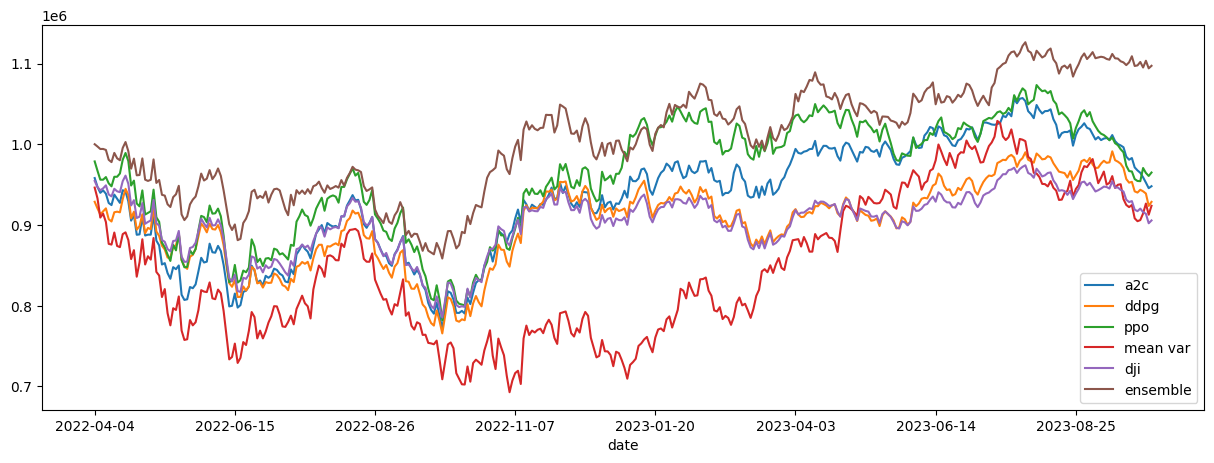

In [58]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();